# 2D Gaussian fitting of selected spot
In this notebook, I will use the approach developed in my previous notebook to analyze all the frames in a stacked tiff file.  All the spots will be fit to a 2D Gaussian to obtain their sub-pixel localizaion. Based on the fit parameter we will create a criteria for classifying the spots in to good and bad spots.

# Import

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import misc
from scipy.ndimage import filters
from skimage.feature import peak_local_max
from scipy.optimize import curve_fit
import pickle

# Loading the saved spot images

In [2]:
from tifffile import TiffFile
with TiffFile('small_tiff.tif') as tif:
    images = np.transpose(tif.asarray()).astype('i2')

### Input Data and filters 

In [3]:
v0 = images
g1 = np.array([1/16,1/4,3/8,1/4,1/16])
g2 = np.array([1/16,0,1/4,0,3/8,0,1/4,0,1/16])

### Convolution of the input data

In [4]:
v1 = filters.convolve1d(filters.convolve1d(v0,g1,axis=1),g1,axis=0)
v2 = filters.convolve1d(filters.convolve1d(v1,g2,axis=1),g2,axis=0)

### Calculating the first and the second wavelet transforms

In [5]:
w1 = np.abs(v0-v1)
w2 = np.abs(v1-v2)
num_frames = v0.shape[2]


Below I am looping through all the frames and selecting spots in each of them. The coordinates are save in spots.

In [6]:
spots = np.empty(shape=[0,3],dtype=np.int)
for i in range(num_frames):
    original = v0[:,:,i]
    wav_1 = w1[:,:,i]
    wav_2 = w2[:,:,i]
    img_mean = np.mean(wav_1)
    img_std = np.std(wav_1)
    coordinates = peak_local_max(wav_2, min_distance=2,threshold_abs=img_mean+1.75*img_std,exclude_border=10)
    coordinates = np.hstack([np.ones((len(coordinates),1),dtype=np.int)*i,coordinates])
    spots = np.append(spots,coordinates,axis=0)


In [7]:
print ("There are a total of {} spots detected in {} frames.".format(spots.shape[0],num_frames))

There are a total of 3215 spots detected in 500 frames.


#  Saving all the spots
Each of the spots identified in the stacked tiff is saved in an array. The images are saved as 9 X 9 array.

In [8]:
no_pixels = 4
image = np.zeros((2*no_pixels+1,2*no_pixels+1,spots.shape[0]), 'i2')
for j,i in enumerate(spots):
    img_temp=v0[i[1]-no_pixels:i[1]+no_pixels+1,i[2]-no_pixels:i[2]+no_pixels+1,i[0]]
    image[:,:,j] = img_temp
    
from tifffile import imsave
imsave('many_spots.tif', image.T,metadata={'axes': 'XYZ'})    

# Testing 2D Gaussian fitting
Below I pick a test spot image and fit it to a 2D Gaussian. This is to test how well the fitting will work.

In [9]:
test1 = image[:,:,5] #Test Image

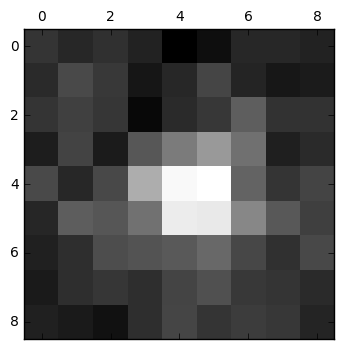

In [10]:
plt.matshow(test1,cmap='gray') # Plotting the test image
plt.show()

### Function to calculate the 2D Gaussian

In [11]:
def D2Gauss(data_tuple,amp,x0,y0,sigx,sigy,offset):
    (x,y) = data_tuple
    xdim = ((x-x0)**2)/(2*sigx**2)
    ydim = ((y-y0)**2)/(2*sigy**2)
    g = offset + amp*np.exp(-xdim-ydim)
    return g.ravel()

### Meshgrid used for the 2D Gaussian fitting

In [12]:
x = np.linspace(0,2*no_pixels,2*no_pixels+1)
y = np.linspace(0,2*no_pixels,2*no_pixels+1)
x,y = np.meshgrid(x,y)

### Initial guess and bounds

In [13]:
initial_guess = (500,3,3,1,1,800)
bounds = ((150,1,1,0.5,0.5,400),(20000,8,8,5,5,2000)) # 4 pixel or less
#bounds = ((150,1,1,0.5,0.5,400),(20000,10,10,5,5,2000)) # more than 4

In [14]:
### Performing the fit

In [15]:
popt, pconv = curve_fit(D2Gauss,(x,y),test1.ravel(),p0=initial_guess,bounds=bounds)

## Plotting the fit over original image

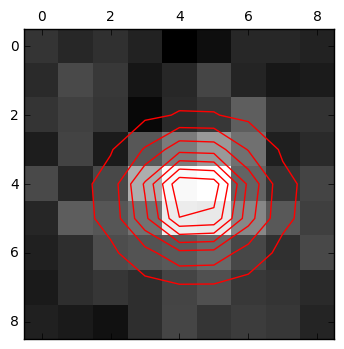

In [16]:
data_fitted = D2Gauss((x, y),*popt)

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.matshow(test1, cmap=plt.cm.gray)
ax.contour(x, y, data_fitted.reshape(2*no_pixels+1, 2*no_pixels+1), 8, colors='r')
plt.show()

The fit looks very good !

In [17]:
print ("The fit parameters are :")
print ("Amplitude = {}".format(popt[0]))
print ("Location x = {}".format(popt[1]))
print ("Location y = {}".format(popt[2]))
print ("Std dev x = {}".format(popt[3]))
print ("Std dev y = {}".format(popt[4]))
print ("Background = {}".format(popt[5]))
print ("These paramater appear reasonable for a diffraction limited spot image.")

The fit parameters are :
Amplitude = 1253.2695599232247
Location x = 4.452955264834776
Location y = 4.37562099703406
Std dev x = 1.164321425465407
Std dev y = 1.0170142931691022
Background = 1283.164215111914
These paramater appear reasonable for a diffraction limited spot image.


## Applying fit to all spot

In [18]:
#fitting all the spots
#save as frame, loc_x,loc_y, amp, x, y , sigmax,sigmay, offset
from time import time
spot_fits = np.empty(shape=[0,9])

x = np.linspace(0,2*no_pixels,2*no_pixels+1)
y = np.linspace(0,2*no_pixels,2*no_pixels+1)
x,y = np.meshgrid(x,y)

bounds = ((150,1,1,0.5,0.5,400),(20000,8,8,5,5,2000)) # 4 pixel or less
#bounds = ((150,1,1,0.5,0.5,400),(20000,10,10,5,5,2000)) # more than 4
initial_guess = (500,3,3,1,1,800)
t0 = time()
for spot in range (spots.shape[0]):
    test1 = image[:,:,spot]
    try:
        popt, pconv = curve_fit(D2Gauss,(x,y),test1.ravel(),p0=initial_guess,bounds=bounds)
    except RuntimeError:
        popt = np.array([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
        print (spot)
        
    fit_param = np.resize(np.hstack([spots[spot],popt]),(1,9))
    spot_fits = np.append(spot_fits,fit_param,axis=0)
total_time = time()-t0
print ('Total = {} sec'.format(total_time))
print ('Time per spot = {} sec'.format(total_time/spots.shape[0]))

Total = 37.82998299598694 sec
Time per spot = 0.011766713218036374 sec


# Creating a dataframe for all spots

In [19]:
import pandas as pd
fit_info = pd.DataFrame(spot_fits,columns=['Frame','xstart','ystart',
                                          'Amp','xc','yc','sigx','sigy','offset'])

In [20]:
fit_info.head()

,Frame,xstart,ystart,Amp,xc,yc,sigx,sigy,offset
0,0.0,12.0,79.0,420.837683,4.268698,4.358847,3.399107,1.925208,1121.966351
1,0.0,56.0,66.0,1374.380229,3.990416,3.673524,1.051023,1.115426,1240.530749
2,0.0,59.0,98.0,455.243100,3.662715,3.333807,2.223357,2.104375,1396.773988
3,0.0,63.0,31.0,745.852520,4.293561,3.974905,1.169750,1.474255,1154.388030
4,0.0,63.0,47.0,942.290175,3.910134,3.806269,1.399729,1.796900,1250.258350


# Statistics on fit parameters
Below I look at the statistics of the fit parameters for all the spots. Based  on these I will create a criteria for classification of spots into good and bad spots

### Amplitude

Minimum: 150.0002396885977
Maximum: 10294.432771273167
Median: 754.1805102173295
Mean: 1083.494945522198
Stdev: 964.2692016303525


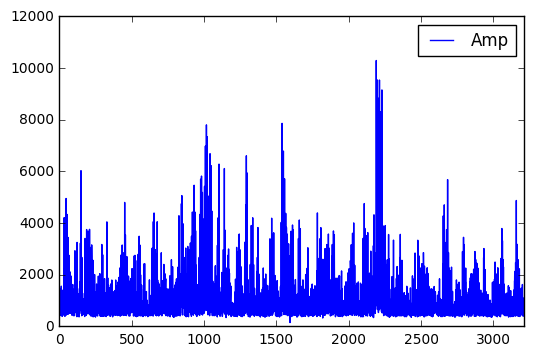

In [21]:
print ('Minimum: {}'.format(fit_info.Amp.min()))
print ('Maximum: {}'.format(fit_info.Amp.max()))
print ('Median: {}'.format(fit_info.Amp.median()))
print ('Mean: {}'.format(fit_info.Amp.mean()))
print ('Stdev: {}'.format(fit_info.Amp.std()))
fit_info.Amp.plot(legend='Amp')
plt.show()

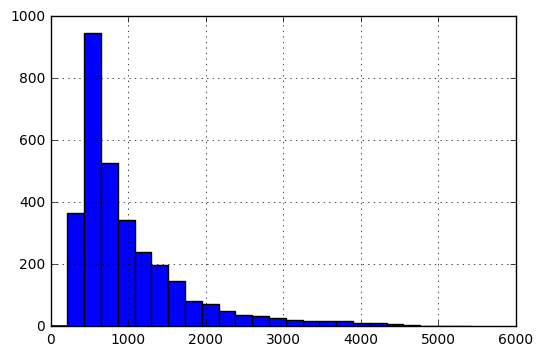

In [22]:
fit_info.Amp.hist(range=(0,5*fit_info.Amp.mean()),bins=25)
plt.show()

### Stdev x

Minimum: 0.5000000003528015
Maximum: 4.999999999999999
Mean: 1.596667711296577
Stdev: 0.7449725717826168


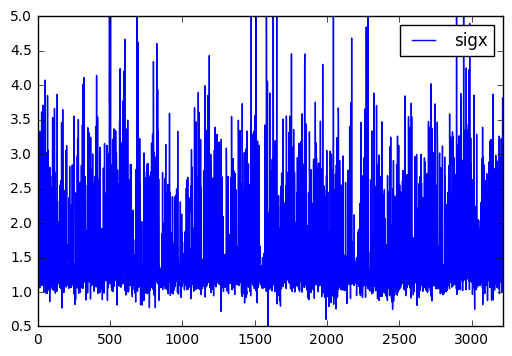

In [23]:
print ('Minimum: {}'.format(fit_info.sigx.min()))
print ('Maximum: {}'.format(fit_info.sigx.max()))
print ('Mean: {}'.format(fit_info.sigx.mean()))
print ('Stdev: {}'.format(fit_info.sigx.std()))
fit_info.sigx.plot(legend='sigx')
plt.show()

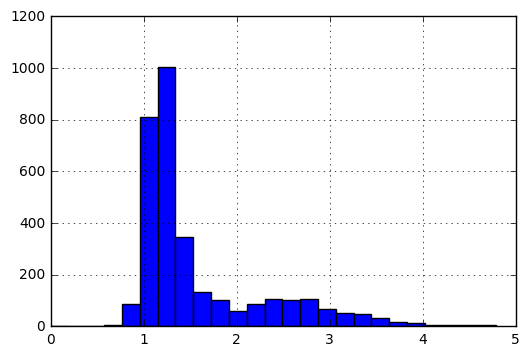

In [24]:
fit_info.sigx.hist(range=(0,3*fit_info.sigx.mean()),bins=25)
plt.show()

### Stdev y

Minimum: 0.5000000018254618
Maximum: 4.999999999999999
Mean: 1.716098078902225
Stdev: 0.9347368286040251


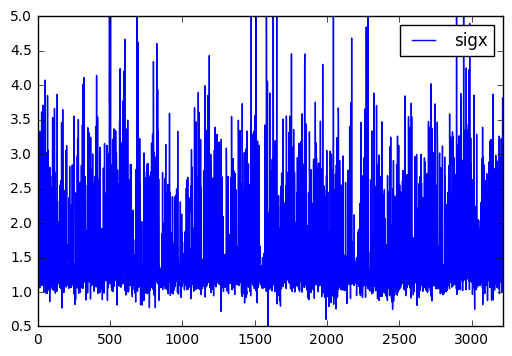

In [25]:
print ('Minimum: {}'.format(fit_info.sigy.min()))
print ('Maximum: {}'.format(fit_info.sigy.max()))
print ('Mean: {}'.format(fit_info.sigy.mean()))
print ('Stdev: {}'.format(fit_info.sigy.std()))
fit_info.sigx.plot(legend='sigy')
plt.show()

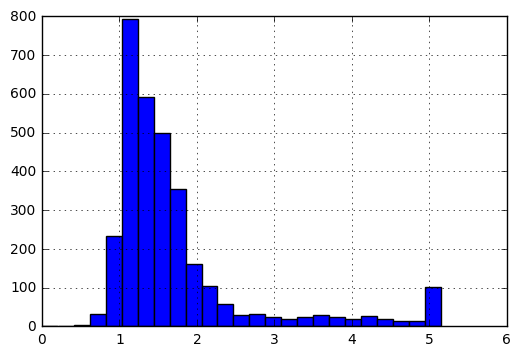

In [26]:
fit_info.sigy.hist(range=(0,3*fit_info.sigy.mean()),bins=25)
plt.show()

### Background

Minimum: 655.0065178157334
Maximum: 1641.734696381115
Mean: 1218.6771661547743
Stdev: 93.45568906320649


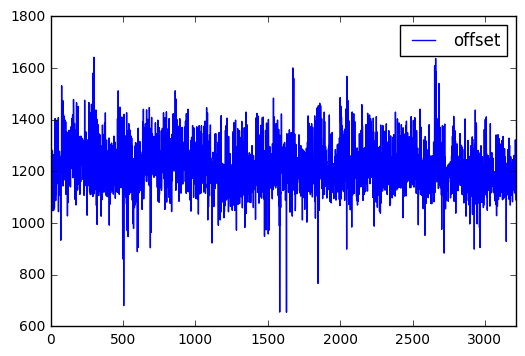

In [27]:
print ('Minimum: {}'.format(fit_info.offset.min()))
print ('Maximum: {}'.format(fit_info.offset.max()))
print ('Mean: {}'.format(fit_info.offset.mean()))
print ('Stdev: {}'.format(fit_info.offset.std()))
fit_info.offset.plot(legend='offset')
plt.show()

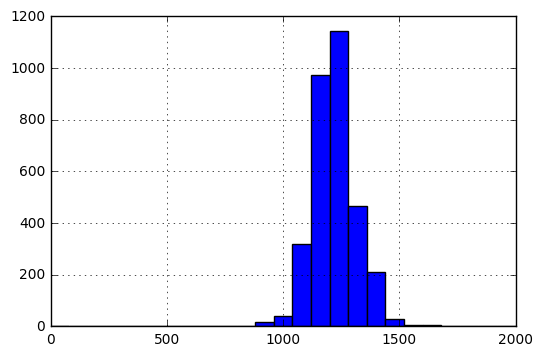

In [28]:
fit_info.offset.hist(range=(0,2000),bins=25)
plt.show()

### Location x

Minimum: 1.0000000000000002
Maximum: 7.999999999999999
Mean: 3.913010731656045
Stdev: 0.6172742593643034


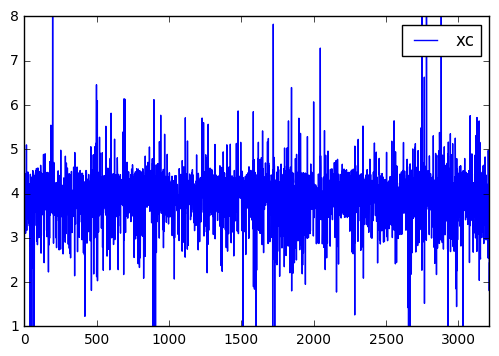

In [29]:
print ('Minimum: {}'.format(fit_info.xc.min()))
print ('Maximum: {}'.format(fit_info.xc.max()))
print ('Mean: {}'.format(fit_info.xc.mean()))
print ('Stdev: {}'.format(fit_info.xc.std()))
fit_info.xc.plot(legend='offset')
plt.show()

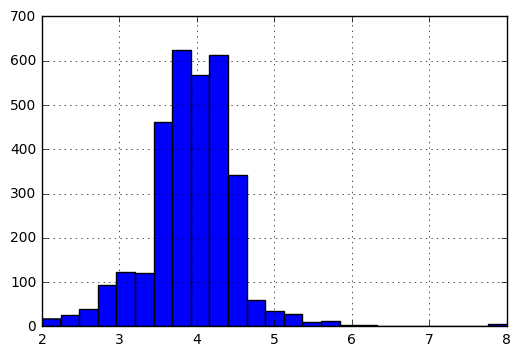

In [30]:
fit_info.xc.hist(range=(2,8),bins=25)
plt.show()

### Location 

Minimum: 1.0000000000000002
Maximum: 7.999999999999999
Mean: 4.071208175945098
Stdev: 0.6188616365161617


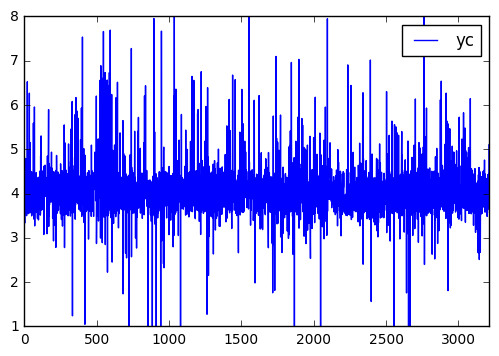

In [31]:
print ('Minimum: {}'.format(fit_info.yc.min()))
print ('Maximum: {}'.format(fit_info.yc.max()))
print ('Mean: {}'.format(fit_info.yc.mean()))
print ('Stdev: {}'.format(fit_info.yc.std()))
fit_info.yc.plot(legend='offset')
plt.show()

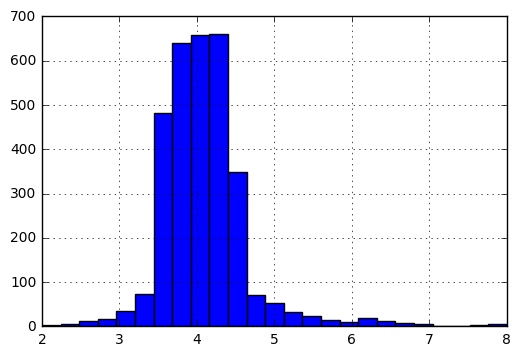

In [32]:
fit_info.yc.hist(range=(2,8),bins=25)
plt.show()

## Creating a mask for spot classification

In [33]:
# Criteria based no amplitude
mask_Amp = (fit_info.Amp>fit_info.Amp.median()-3.5*fit_info.Amp.min()) & (fit_info.Amp<20*fit_info.Amp.mean())

# Criteria for sigx and sigy. These are based on the information that the spot image is 
# diffraction limited
mask_sigx = (fit_info.sigx>0.5) & (fit_info.sigx<1.0*fit_info.sigx.mean())
mask_sigy = (fit_info.sigy>0.5) & (fit_info.sigy<1.0*fit_info.sigy.mean())

#I expect the spots to be away from the edges
mask_xc = (fit_info.xc>fit_info.xc.mean() - no_pixels+2) & (fit_info.xc<fit_info.xc.mean() + no_pixels-2)
mask_yc = (fit_info.yc>fit_info.yc.mean() - no_pixels+2) & (fit_info.yc<fit_info.yc.mean() + no_pixels-2)

#Overall mask
mask_overall = mask_Amp & mask_sigx & mask_sigy & mask_xc & mask_yc


In [34]:
print ("There are {} good spots out of total {} spots".format(sum(mask_overall),spots.shape[0]))

There are 2047 good spots out of total 3215 spots


## Creating database for the good and the bad spots

In [35]:
good_spots = fit_info[mask_overall]
good_spots.head()
#good_spots.shape

,Frame,xstart,ystart,Amp,xc,yc,sigx,sigy,offset
1,0.0,56.0,66.0,1374.380229,3.990416,3.673524,1.051023,1.115426,1240.530749
3,0.0,63.0,31.0,745.852520,4.293561,3.974905,1.169750,1.474255,1154.388030
5,0.0,79.0,43.0,1253.269560,4.452955,4.375621,1.164321,1.017014,1283.164215
6,0.0,88.0,44.0,1456.702499,4.159699,3.702994,1.171062,1.010953,1245.558466
9,1.0,56.0,66.0,1225.947609,4.110754,3.551222,1.127565,1.231370,1202.746821


In [36]:
bad_spots = fit_info[~mask_overall]
bad_spots.head()

,Frame,xstart,ystart,Amp,xc,yc,sigx,sigy,offset
0,0.0,12.0,79.0,420.837683,4.268698,4.358847,3.399107,1.925208,1121.966351
2,0.0,59.0,98.0,455.243100,3.662715,3.333807,2.223357,2.104375,1396.773988
4,0.0,63.0,47.0,942.290175,3.910134,3.806269,1.399729,1.796900,1250.258350
7,0.0,102.0,17.0,424.731248,3.483048,3.957906,2.749014,1.601426,1161.430637
8,1.0,51.0,98.0,587.178282,3.103617,4.793556,3.097667,4.254575,1106.570356


### Adding the classification information to the overall database

In [37]:
fit_info['target'] = mask_overall
fit_info.head()

,Frame,xstart,ystart,Amp,xc,yc,sigx,sigy,offset,target
0,0.0,12.0,79.0,420.837683,4.268698,4.358847,3.399107,1.925208,1121.966351,False
1,0.0,56.0,66.0,1374.380229,3.990416,3.673524,1.051023,1.115426,1240.530749,True
2,0.0,59.0,98.0,455.243100,3.662715,3.333807,2.223357,2.104375,1396.773988,False
3,0.0,63.0,31.0,745.852520,4.293561,3.974905,1.169750,1.474255,1154.388030,True
4,0.0,63.0,47.0,942.290175,3.910134,3.806269,1.399729,1.796900,1250.258350,False


## Saving the data 
I am saving the images and the 2D Gaussian analysis as a Bunch object. This will be helpful in future for analysis of this dataset using scikit-learn. Each image is converted into 1D array before saving. The bunch object will contain these flattened images, and thier classifications.

In [38]:
from sklearn.datasets.base import Bunch

In [39]:
print (" Original shape of the image stack = {}".format(image.shape))

 Original shape of the image stack = (9, 9, 3215)


In [40]:
image_2 = np.transpose(np.reshape(image,(image.shape[0]*image.shape[1],image.shape[2])))

In [41]:
print ("Shape of image stack after flattening each image = {}".format(image_2.shape))

Shape of image stack after flattening each image = (3215, 81)


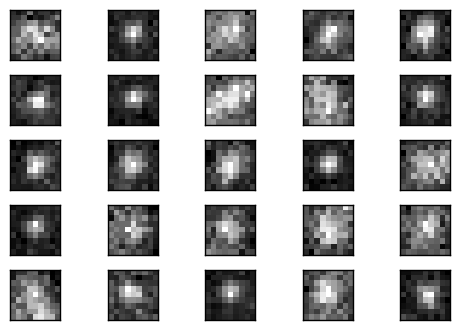

In [42]:
# Plotting few images from overall dataset

fig, axes = plt.subplots(5,5)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i, ax in enumerate(axes.flat):
    ax.matshow(image_2[i].reshape(image.shape[0],image.shape[1]),cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    

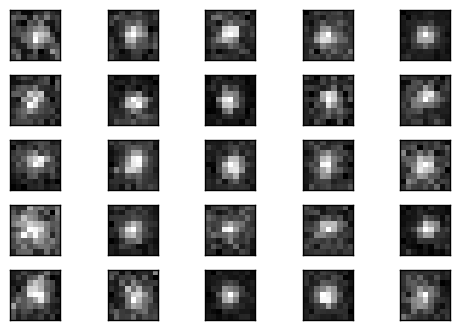

In [51]:
# Plotting few images from good spots
fig, axes = plt.subplots(5,5)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i, ax in zip(np.random.choice(good_spots.index,5*5),axes.flat):
    ax.matshow(image_2[i].reshape(image.shape[0],image.shape[1]),cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

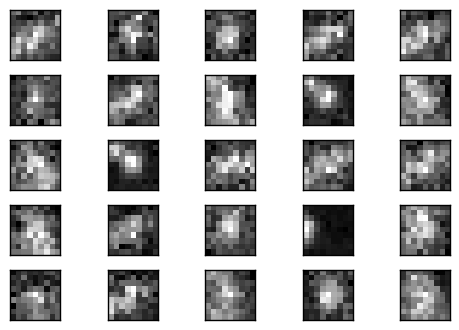

In [48]:
# Plotting few images from bad spots
fig, axes = plt.subplots(5,5)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i, ax in zip(np.random.choice(bad_spots.index,5*5),axes.flat):
    ax.matshow(image_2[i].reshape(image.shape[0],image.shape[1]),cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])


## Creating Bunch object

In [45]:
spot_image = Bunch(data=image_2,target=fit_info.target,fit_params=fit_info)

## Pickle the Bunch object

In [46]:
with open('spot_image_data.pkl','wb') as fid:
    pickle.dump(spot_image,fid)

I will use this dataset in the next notebook to train a classifier